In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from matplotlib.backends.backend_pdf import PdfPages
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
#pd.options.mode.copy_on_write = True
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import multiprocessing as mp
from tqdm import tqdm
cosmo = FlatLambdaCDM(name='Planck18', H0=67.66, Om0=0.30966, Tcmb0=2.7255, Neff=3.046, m_nu=[0.  , 0.  , 0.06]* u.eV, Ob0=0.04897)
cores = 8

In [2]:
sys.path.append('../UploadToFritz')
import GetLightcurve

def get_fphot(data):
    objid, crossmatch = data
    df_photometry = GetLightcurve.full_dataframe([objid, crossmatch])[['STANDARD_NAME', 'SEMESTER_NAME', 'SCIENCE_NAME', 'TEMPLATE_NAME', 'MJD_OBS', 'FILTER', 'DETPOS',
       'X_OBJ', 'Y_OBJ', 'X_FPHOT', 'Y_FPHOT', 'X_nSTAR', 'Y_nSTAR', 'X_nGAL',
       'Y_nGAL', 'X_ALT', 'Y_ALT', 'MAG_ALT', 'MAGERR_ALT', 'SNR_ALT',
       'CNNSCORE_ALT', 'ZMIN_TEMP', 'ZMAX_TEMP', 'ZMIN_SCI', 'ZMAX_SCI',
       'ZMIN_DIFF', 'ZMAX_DIFF', 'APER_FPHOT', 'ZP_FPHOT', 'LIM_MAG3',
       'LIM_MAG5', 'MAG_FPHOT', 'MAGERR_FPHOT', 'SNR_FPHOT', 'STATUS_FPHOT',
       'REAL', 'LIMIT']]
    
    df_photometry.drop_duplicates(subset = ["MAG_FPHOT", "MAGERR_FPHOT", "MJD_OBS", "FILTER"], inplace = True)
    
    return df_photometry

In [3]:
crossmatch_df =  pd.read_csv('../MatchToDESI/candidates_desi.csv')
interesting_df =  pd.read_csv('../MatchToDESI/interesting_desi.csv')

In [4]:
queue = [[i, interesting_df] for i in interesting_df["STANDARD_NAME"]]
pool = mp.Pool(processes=cores)
interesting_lightcurve_dfs = list(tqdm(pool.imap_unordered(get_fphot, queue), total = len(queue)))
interesting_lightcurves_df = pd.concat(interesting_lightcurve_dfs)

100%|██████████| 649/649 [00:11<00:00, 57.66it/s]


In [5]:
queue = [[i, crossmatch_df] for i in crossmatch_df["STANDARD_NAME"]]
pool = mp.Pool(processes=cores)
crossmatch_lightcurve_dfs = list(tqdm(pool.imap_unordered(get_fphot, queue), total = len(queue)))
crossmatch_lightcurve_df = pd.concat(crossmatch_lightcurve_dfs)

100%|██████████| 2339/2339 [00:35<00:00, 65.47it/s]


In [6]:
interesting_lightcurves_table = Table.from_pandas(interesting_lightcurves_df)
interesting_table = Table.from_pandas(interesting_df)
crossmatch_lightcurves_table = Table.from_pandas(crossmatch_lightcurve_df)
crossmatch_table = Table.from_pandas(crossmatch_df)

In [7]:
filter_dict = {"g" : "green", "i" : "indigo" , "r" : "red", "z" : "orange"}

In [8]:
#C202208032106241p061948 Good example

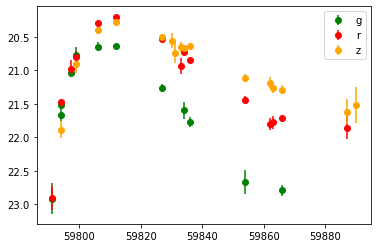

In [9]:
row = interesting_table[203]
lc = interesting_lightcurves_table[np.where(interesting_lightcurves_table["STANDARD_NAME"] == row["STANDARD_NAME"])]
lc_real = lc[lc["REAL"]]
brightest_mag = lc_real[np.argmin(lc_real["MAG_FPHOT"])]
for i in np.unique(lc_real["FILTER"]):
    lc_real_filter = lc_real[np.where(lc_real["FILTER"] == i)]
    plt.errorbar(lc_real_filter["MJD_OBS"], lc_real_filter["MAG_FPHOT"], lc_real_filter["MAGERR_FPHOT"], fmt = "o", color = filter_dict[i], label = i)
plt.legend()
plt.gca().invert_yaxis()

In [10]:
num_filters = len(np.unique(lc_real["FILTER"]))
before_max = len(lc_real[(lc_real["MJD_OBS"] < brightest_mag["MJD_OBS"])]) > 4
after_max = len(lc_real[(lc_real["MJD_OBS"] > brightest_mag["MJD_OBS"])]) > 6
ample_observations = before_max and after_max
ample_observations

True

In [11]:
def good_example(data):
    row, lc = data
    lc_real = lc[lc["REAL"]]
    brightest_mag = lc_real[np.argmin(lc_real["MAG_FPHOT"])]
    good = []
    for i in np.unique(lc_real["FILTER"]):
        lc_real_filter = lc_real[np.where(lc_real["FILTER"] == i)]
        before_max = len(lc_real_filter[(lc_real_filter["MJD_OBS"] < brightest_mag["MJD_OBS"])]) > 4
        after_max = len(lc_real_filter[(lc_real_filter["MJD_OBS"] > brightest_mag["MJD_OBS"])]) > 6
        ample_observations = before_max and after_max
        good.append(ample_observations)
        
    return np.sum(good) > 0

In [12]:
interesting_lightcurves_table

STANDARD_NAME,SEMESTER_NAME,SCIENCE_NAME,TEMPLATE_NAME,MJD_OBS,FILTER,DETPOS,X_OBJ,Y_OBJ,X_FPHOT,Y_FPHOT,X_nSTAR,Y_nSTAR,X_nGAL,Y_nGAL,X_ALT,Y_ALT,MAG_ALT,MAGERR_ALT,SNR_ALT,CNNSCORE_ALT,ZMIN_TEMP,ZMAX_TEMP,ZMIN_SCI,ZMAX_SCI,ZMIN_DIFF,ZMAX_DIFF,APER_FPHOT,ZP_FPHOT,LIM_MAG3,LIM_MAG5,MAG_FPHOT,MAGERR_FPHOT,SNR_FPHOT,STATUS_FPHOT,REAL,LIMIT
str23,str23,bytes30,bytes28,float64,bytes1,bytes3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,bool,bool
C202212280349025m145944,C202212280349025m145944,c4d_220909_090838_xxx_r_v1,c4d_141121_064157_xxx_r_v1,59831.38100498,r,S24,431.1702157190084,43.21766671227086,431.59777832043073,42.73094177239233,387.1261078040752,34.45539825096141,432.70922160552254,43.1020888719013,--,--,--,--,--,--,-30.742584,58.69988253231526,-82.2502064577472,84.24201368219116,-85.88097214665413,85.88097214665413,19.29,28.74065,21.362956777032537,20.808334902991646,19.608921676525178,0.06209992576339317,17.483112687390708,q,True,False
C202212280349025m145944,C202212280349025m145944,c4d_220911_082534_xxx_r_v1,c4d_141121_064157_xxx_r_v1,59833.35109043,r,S24,431.1702157190084,43.21766671227086,431.59777832043073,42.73094177239233,387.1261078040752,34.45539825096141,432.70922160552254,43.1020888719013,--,--,--,--,--,--,-30.742584,58.69988253231526,-61.83274,116.42456114469378,-116.38560321255288,116.38560321255288,12.95,28.945336,21.79845014617203,21.24382827213114,23.09122320202659,1.0751439218114216,1.0098182931367863,m,False,True
C202212280349025m145944,C202212280349025m145944,c4d_220912_080230_xxx_r_v1,c4d_141121_064157_xxx_r_v1,59834.33507951,r,S24,431.1702157190084,43.21766671227086,431.59777832043073,42.73094177239233,387.1261078040752,34.45539825096141,432.70922160552254,43.1020888719013,--,--,--,--,--,--,-30.742584,58.69988253231526,-92.6552873066002,70.09758,-101.69312365729519,101.69312365729519,4.99,29.029946,23.040964310636063,22.486342436595173,23.341812499178705,0.43063230219649756,2.5211764060945785,m,False,True
C202212280349025m145944,C202212280349025m145944,c4d_221116_071325_xxx_r_v1,c4d_141121_064157_xxx_r_v1,59899.30099,r,S24,431.1702157190084,43.21766671227086,431.59777832043073,42.73094177239233,387.1261078040752,34.45539825096141,432.70922160552254,43.1020888719013,--,--,--,--,--,--,-30.742584,58.69988253231526,-52.74317,57.38077686408064,-77.88008181988734,77.88008181988734,4.75,29.596187,23.841024023739774,23.286402149698883,27.115229342336107,5.84937905399787,0.18560944503296598,m,False,True
C202212280349025m145944,C202212280349025m145944,c4d_221122_061843_xxx_r_v1,c4d_141121_064157_xxx_r_v1,59905.26299819,r,S24,431.1702157190084,43.21766671227086,431.59777832043073,42.73094177239233,387.1261078040752,34.45539825096141,432.70922160552254,43.1020888719013,--,--,--,--,--,--,-30.742584,58.69988253231526,-34.58329,39.724838155443074,-52.17622354292554,52.17622354292554,4.76,29.359322,24.042833492322,23.488211618281106,25.87706827212948,1.6541751980926012,0.6563391841758363,m,False,True
C202212280349025m145944,C202212280349025m145944,c4d_221125_060533_xxx_r_v1,c4d_141121_064157_xxx_r_v1,59908.25386226,r,S24,431.1702157190084,43.21766671227086,431.59777832043073,42.73094177239233,387.1261078040752,34.45539825096141,432.70922160552254,43.1020888719013,--,--,--,--,--,--,-30.742584,58.69988253231526,-21.731567,41.70760104938254,-66.65906231020118,66.65906231020118,4.75,29.596187,24.056438869121024,23.501816995080134,25.418976677159755,1.1048468597497745,0.9826701233923851,m,False,True
C202212280349025m145944,C202212280349025m145944,c4d_221213_052401_xxx_r_v1,c4d_141121_064157_xxx_r_v1,59926.22502244,r,S24,431.1702157190084,43.21766671227086,431.59777832043073,42.73094177239233,387.1261078040752,34.45539825096141,432.70922160552254,43.1020888719013,--,--,--,--,--,--,-30.742584,58.69988253231526,-65.7235621978189,66.7654275621759,-68

In [12]:
queue = [[i, interesting_lightcurves_table[np.where(interesting_lightcurves_table["STANDARD_NAME"] == i["STANDARD_NAME"])]] for i in interesting_table]
pool = mp.Pool(processes=cores)
good_list = list(tqdm(pool.imap(good_example, queue), total = len(queue)))

100%|██████████| 649/649 [00:03<00:00, 197.81it/s]


In [13]:
p = PdfPages('good_interesting_transients.pdf')
for row in interesting_table[good_list]:
    curfig = plt.figure(figsize=[10,6])
    lc = interesting_lightcurves_table[np.where(interesting_lightcurves_table["STANDARD_NAME"] == row["STANDARD_NAME"])]
    lc_real = lc[lc["REAL"]]
    brightest_mag = lc_real[np.argmin(lc_real["MAG_FPHOT"])]
    for i in np.unique(lc_real["FILTER"]):
        lc_real_filter = lc_real[np.where(lc_real["FILTER"] == i)]
        before_max = len(lc_real_filter[(lc_real_filter["MJD_OBS"] < brightest_mag["MJD_OBS"])]) > 4
        after_max = len(lc_real_filter[(lc_real_filter["MJD_OBS"] > brightest_mag["MJD_OBS"])]) > 6

        plt.errorbar(lc_real_filter["MJD_OBS"], lc_real_filter["MAG_FPHOT"], lc_real_filter["MAGERR_FPHOT"], fmt = "o", color = filter_dict[i], label = i)
        #plt.scatter(lc_real_filter["MJD_OBS"], np.power(10, lc_real_filter["MAG_FPHOT"] / (-2.5)), color = filter_dict[i], label = i)
    plt.legend()
    plt.gca().invert_yaxis()
    plt.title("{} z = {:.3f} SPECTYPE = {}".format(row["STANDARD_NAME"], row["Z"], row["SPECTYPE"]))
    p.savefig(curfig)
    plt.close()
p.close() 

In [103]:
def good_tde(data):
    row, lc = data
    lc_real = lc[lc["REAL"]]
    brightest_mag = lc_real[np.argmin(lc_real["MAG_FPHOT"])]

    lc_real_g = lc_real[np.where(lc_real["FILTER"] == "g")]
    lc_real_r = lc_real[np.where(lc_real["FILTER"] == "r")]

    if(len(lc_real_g) < 5 or len(lc_real_r) < 5):
        return 99.0
    
    g_r = np.nanmean(lc_real_g["MAG_FPHOT"]) - np.nanmean(lc_real_r["MAG_FPHOT"])
        
    return g_r

In [104]:
queue = [[i, interesting_lightcurves_table[np.where(interesting_lightcurves_table["STANDARD_NAME"] == i["STANDARD_NAME"])]] for i in interesting_table]
pool = mp.Pool(processes=cores)
good_tde_list = np.array(list(tqdm(pool.imap(good_tde, queue), total = len(queue))))

100%|██████████| 649/649 [00:01<00:00, 396.21it/s]


In [105]:
queue = [[i, crossmatch_lightcurves_table[np.where(crossmatch_lightcurves_table["STANDARD_NAME"] == i["STANDARD_NAME"])]] for i in crossmatch_table]
pool = mp.Pool(processes=cores)
crossmatch_tde_list = np.array(list(tqdm(pool.imap(good_tde, queue), total = len(queue))))

100%|██████████| 2339/2339 [00:06<00:00, 334.23it/s]


In [106]:
p = PdfPages('tde_crossmatch_transients.pdf')
for row in crossmatch_table[crossmatch_tde_list < 0.2]:
    curfig = plt.figure(figsize=[10,6])
    lc = crossmatch_lightcurves_table[np.where(crossmatch_lightcurves_table["STANDARD_NAME"] == row["STANDARD_NAME"])]
    lc_real = lc[lc["REAL"]]
    for i in np.unique(lc_real["FILTER"]):
        lc_real_filter = lc_real[np.where(lc_real["FILTER"] == i)]
        before_max = len(lc_real_filter[(lc_real_filter["MJD_OBS"] < brightest_mag["MJD_OBS"])]) > 4
        after_max = len(lc_real_filter[(lc_real_filter["MJD_OBS"] > brightest_mag["MJD_OBS"])]) > 6

        plt.errorbar(lc_real_filter["MJD_OBS"], lc_real_filter["MAG_FPHOT"], lc_real_filter["MAGERR_FPHOT"], fmt = "o", color = filter_dict[i], label = i)
        #plt.scatter(lc_real_filter["MJD_OBS"], np.power(10, lc_real_filter["MAG_FPHOT"] / (-2.5)), color = filter_dict[i], label = i)
    plt.legend()
    plt.gca().invert_yaxis()
    plt.title("{} z = {:.3f} SPECTYPE = {}".format(row["STANDARD_NAME"], row["Z"], row["SPECTYPE"]))
    p.savefig(curfig)
    plt.close()
p.close() 

In [108]:
crossmatchall_df =  pd.read_csv('../CrossMatch/DESIRT_one_arcsecond_crossmatch_all_objects.csv')

In [110]:
standard_names = []

for row in crossmatchall_df.iterrows():
    
    for i in [0, 1, 2, 3, 4]:

        if not pd.isnull(row[1][i]):

            standard_names.append(row[1][i])
            
            break

crossmatchall_df['STANDARD_NAME'] = standard_names
crossmatchall_df = crossmatchall_df[['STANDARD_NAME', '21A', '22A', '22B', '23A', '23B', 'ra_obj', 'dec_obj']]

In [111]:
crossmatchall_df.head()

,STANDARD_NAME,21A,22A,22B,23A,23B,ra_obj,dec_obj
0,C202210020000005m002704,NaN,NaN,C202210020000005m002704,NaN,NaN,0.001904,-0.451054
1,T202209140000007p000606,NaN,NaN,T202209140000007p000606,NaN,T202308020000007p000606,0.002768,0.101728
2,T202210260000009p003229,NaN,NaN,T202210260000009p003229,NaN,T202308130000010p003230,0.003874,0.541530
3,T202209090000014p001817,NaN,NaN,T202209090000014p001817,NaN,NaN,0.005892,0.304686
4,T202210020000016p003460,NaN,NaN,T202210020000016p003460,NaN,T202308130000017p003460,0.006866,0.583236


In [112]:
queue = [[i, crossmatchall_df] for i in crossmatchall_df["STANDARD_NAME"]]
pool = mp.Pool(processes=cores)
crossmatchall_lightcurve_dfs = list(tqdm(pool.imap_unordered(get_fphot, queue), total = len(queue)))
crossmatchall_lightcurve_df = pd.concat(crossmatchall_lightcurve_dfs)

100%|██████████| 27127/27127 [13:05<00:00, 34.52it/s]


In [114]:
crossmatchall_lightcurve_df.to_csv("~/tmp_ondemand_hildafs_phy220048p_symlink/xhall/DESIRT_Candidate_LCs/crossmatchall_lightcurve.csv", index = False)

In [117]:
crossmatchall_lightcurve_table = Table.from_pandas(crossmatchall_lightcurve_df)
crossmatchall_table = Table.from_pandas(crossmatchall_df)

In [123]:
def good_tde_all(data):
    row, lc = data
    lc_real = lc[lc["REAL"]]
    if(len(lc_real) < 1):
        return 99.0
    brightest_mag = lc_real[np.argmin(lc_real["MAG_FPHOT"])]

    lc_real_g = lc_real[np.where(lc_real["FILTER"] == "g")]
    lc_real_r = lc_real[np.where(lc_real["FILTER"] == "r")]

    if(len(lc_real_g) < 10 or len(lc_real_r) < 10):
        return 99.0
    
    g_r = np.nanmean(lc_real_g["MAG_FPHOT"]) - np.nanmean(lc_real_r["MAG_FPHOT"])
        
    return g_r

In [120]:
queue = [[i, crossmatchall_lightcurve_table[np.where(crossmatchall_lightcurve_table["STANDARD_NAME"] == i["STANDARD_NAME"])]] for i in crossmatchall_table]

In [124]:
pool = mp.Pool(processes=cores)
crossmatchall_tde_list = np.array(list(tqdm(pool.imap(good_tde_all, queue), total = len(queue))))

100%|██████████| 27127/27127 [06:34<00:00, 68.81it/s]
Process ForkPoolWorker-194:
Process ForkPoolWorker-196:
Process ForkPoolWorker-193:
Process ForkPoolWorker-195:
Process ForkPoolWorker-199:
Process ForkPoolWorker-198:
Process ForkPoolWorker-200:
Process ForkPoolWorker-197:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


In [126]:
np.sum(crossmatchall_tde_list < 0)

1955

In [ ]:
p = PdfPages('tde_crossmatchall_transients.pdf')
for row in crossmatchall_table[crossmatchall_tde_list < 0]:
    curfig = plt.figure(figsize=[10,6])
    lc = crossmatch_lightcurves_table[np.where(crossmatch_lightcurves_table["STANDARD_NAME"] == row["STANDARD_NAME"])]
    lc_real = lc[lc["REAL"]]
    for i in np.unique(lc_real["FILTER"]):
        lc_real_filter = lc_real[np.where(lc_real["FILTER"] == i)]
        plt.errorbar(lc_real_filter["MJD_OBS"], lc_real_filter["MAG_FPHOT"], lc_real_filter["MAGERR_FPHOT"], fmt = "o", color = filter_dict[i], label = i)
        #plt.scatter(lc_real_filter["MJD_OBS"], np.power(10, lc_real_filter["MAG_FPHOT"] / (-2.5)), color = filter_dict[i], label = i)
    plt.legend()
    plt.gca().invert_yaxis()
    plt.title("{}".format(row["STANDARD_NAME"]))
    p.savefig(curfig)
    plt.close()
p.close() 